## Library Imports

In [1]:
# Cell 1
import numpy as np
import pandas as pd
import glob
import os
import logging
import tensorflow as tf
from tqdm import tqdm
from datetime import datetime
from scipy.stats import skew, kurtosis
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

# Pre-processing of files 

In [25]:
# Cell 2
def load_emothaw_data(directory_path):
    """
    Modified to aggregate features per file instead of per row
    """
    all_file_data = []  # Will store one entry per file instead of per row
    all_file_labels = []  # Will store one label per file

    file_paths = glob.glob(os.path.join(directory_path, "*.svc"))
    if not file_paths:
        raise ValueError("No files found in the specified directory")

    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        try:
            # Extract the label from the filename
            label = int(os.path.basename(file_path).split('_')[0])

            with open(file_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]

            df = pd.DataFrame([line.split() for line in lines])

            if df.empty:
                print(f"Warning: {file_path} is empty after processing. Skipping file.")
                continue

            total_rows = int(df.iloc[0, 0])
            data = df.iloc[1:, :].values

            # Validate and reshape data
            reshaped_data = []
            for row in data:
                if len(row) == 7:
                    reshaped_data.append(row)

            if reshaped_data:
                reshaped_data = np.array(reshaped_data, dtype=float)
                
                # Store entire file's data as one entry
                all_file_data.append(reshaped_data)
                all_file_labels.append(label)

                print(f"Processed file {file_path}: Shape {reshaped_data.shape}")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue

    if not all_file_data or not all_file_labels:
        raise ValueError("No valid data found in the directory")

    return all_file_data, np.array(all_file_labels)

# Importing all files on the Directory
data, labels = load_emothaw_data(r'../test/withsynthethic/')  # Directory path


Processing file: ../test/withsynthethic\0_hw00001 (2).svc
Processed file ../test/withsynthethic\0_hw00001 (2).svc: Shape (1702, 7)
Processing file: ../test/withsynthethic\0_hw00001.svc
Processed file ../test/withsynthethic\0_hw00001.svc: Shape (2643, 7)
Processing file: ../test/withsynthethic\0_hw00002 (2).svc
Processed file ../test/withsynthethic\0_hw00002 (2).svc: Shape (3398, 7)
Processing file: ../test/withsynthethic\0_hw00002.svc
Processed file ../test/withsynthethic\0_hw00002.svc: Shape (5691, 7)
Processing file: ../test/withsynthethic\0_hw00003 (2).svc
Processed file ../test/withsynthethic\0_hw00003 (2).svc: Shape (3373, 7)
Processing file: ../test/withsynthethic\0_hw00003.svc
Processed file ../test/withsynthethic\0_hw00003.svc: Shape (3863, 7)
Processing file: ../test/withsynthethic\0_hw00004 (2).svc
Processed file ../test/withsynthethic\0_hw00004 (2).svc: Shape (819, 7)
Processing file: ../test/withsynthethic\0_hw00004.svc
Processed file ../test/withsynthethic\0_hw00004.svc: S

## FEATURE EXTRACTION

In [33]:
# Cell 3
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

def extract_time_domain_features(data_array):
    """
    Modified to handle 3D data (files x samples x features)
    """
    features_per_file = []
    
    for file_data in data_array:
        means = np.mean(file_data, axis=0)
        stds = np.std(file_data, axis=0)
        mins = np.min(file_data, axis=0)
        maxs = np.max(file_data, axis=0)
        percentile_25 = np.percentile(file_data, 25, axis=0)
        percentile_50 = np.percentile(file_data, 50, axis=0)
        percentile_75 = np.percentile(file_data, 75, axis=0)
        
        file_features = np.concatenate([
            means, stds, mins, maxs,
            percentile_25, percentile_50, percentile_75
        ])
        
        features_per_file.append(file_features)
    
    return np.array(features_per_file)

def extract_frequency_domain_features(data_array):
    """
    Modified to handle 3D data (files x samples x features)
    """
    features_per_file = []
    
    for file_data in data_array:
        freq_features = np.fft.fft(file_data, axis=0)
        freq_magnitude = np.abs(freq_features)
        
        dominant_freqs = np.argmax(freq_magnitude, axis=0)
        freq_energies = np.sum(freq_magnitude, axis=0)
        
        file_features = np.concatenate([dominant_freqs, freq_energies])
        features_per_file.append(file_features)
    
    return np.array(features_per_file)

def extract_statistical_features(data_array):
    """
    Modified to handle 3D data (files x samples x features)
    """
    features_per_file = []
    
    for file_data in data_array:
        means = np.mean(file_data, axis=0)
        medians = np.median(file_data, axis=0)
        variances = np.var(file_data, axis=0)
        skewness = skew(file_data, axis=0)
        kurtosis_vals = kurtosis(file_data, axis=0)
        
        file_features = np.concatenate([
            means, medians, variances, skewness, kurtosis_vals
        ])
        features_per_file.append(file_features)
    
    return np.array(features_per_file)

# Example usage:
def process_features(data):
    """
    Process all features at once and combine them
    """
    time_features = extract_time_domain_features(data)
    freq_features = extract_frequency_domain_features(data)
    stat_features = extract_statistical_features(data)
    
    # Combine all features
    combined_features = np.concatenate([
        time_features,
        freq_features,
        stat_features
    ], axis=1)
    
    return combined_features

In [34]:
# Cell 4
data, labels = load_emothaw_data(r'../test/label copy/')

# Extract features per file
time_domain_features = extract_time_domain_features(data)
frequency_domain_features = extract_frequency_domain_features(data)
statistical_features = extract_statistical_features(data)

# Combine features
features = np.concatenate((time_domain_features, frequency_domain_features, statistical_features), axis=1)

print("Features shape per component:")
print(f"Time Domain Features: {time_domain_features.shape}")
print(f"Frequency Domain Features: {frequency_domain_features.shape}")
print(f"Statistical Features: {statistical_features.shape}")
print(f"Combined Features: {features.shape}")

Processing file: ../test/label copy\0_hw00001.svc
Processed file ../test/label copy\0_hw00001.svc: Shape (2643, 7)
Processing file: ../test/label copy\0_hw00002.svc
Processed file ../test/label copy\0_hw00002.svc: Shape (5691, 7)
Processing file: ../test/label copy\0_hw00003.svc
Processed file ../test/label copy\0_hw00003.svc: Shape (3863, 7)
Processing file: ../test/label copy\0_hw00004.svc
Processed file ../test/label copy\0_hw00004.svc: Shape (1178, 7)
Processing file: ../test/label copy\0_hw00005.svc
Processed file ../test/label copy\0_hw00005.svc: Shape (770, 7)
Processing file: ../test/label copy\0_hw00006.svc
Processed file ../test/label copy\0_hw00006.svc: Shape (4051, 7)
Processing file: ../test/label copy\0_hw00007.svc
Processed file ../test/label copy\0_hw00007.svc: Shape (3050, 7)
Processing file: ../test/label copy\1_hw00001.svc
Processed file ../test/label copy\1_hw00001.svc: Shape (2560, 7)
Processing file: ../test/label copy\1_hw00002.svc
Processed file ../test/label co

C:\Users\katod\AppData\Local\Temp\ipykernel_17960\3368346268.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(file_data, axis=0)
C:\Users\katod\AppData\Local\Temp\ipykernel_17960\3368346268.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_vals = kurtosis(file_data, axis=0)


In [35]:
# Cell 5
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        
        # Add numerical stability with cliping
        scaled_score = tf.clip_by_value(scaled_score, -5., 5.)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.BatchNormalization(),  # Added BatchNorm
            layers.Dense(embed_dim)
        ])
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)




## Transformer Block

Transformer Classifier

In [45]:
# Cell 6

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model

class TransformerClassifier(Model):
    def __init__(self, num_classes, embed_dim, num_heads, ff_dim, num_layers):
        super(TransformerClassifier, self).__init__()
        
        # Add input normalization
        self.input_norm = layers.BatchNormalization()
        self.dense_input = layers.Dense(embed_dim, activation='relu')
        
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ]
        
        self.global_average_pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(0.2)  # Added dropout
        self.dense1 = layers.Dense(32, activation='relu')  # Added intermediate layer
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.input_norm(inputs, training=training)
        x = self.dense_input(x)
        x = tf.expand_dims(x, axis=1)  # Add sequence dimension
        
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)
        
        x = self.global_average_pooling(x)
        x = self.dropout(x, training=training)
        x = self.dense1(x)
        return self.dense2(x)

from sklearn.preprocessing import StandardScaler


# Splitting the data into training and testing sets
features = np.concatenate((time_domain_features, frequency_domain_features, statistical_features), axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Defining the model parameters
# Model parameters
num_classes = 4
embed_dim = 128  # Increased embedding dimension
num_heads = 4    # Increased number of heads
ff_dim = 256    # Increased feedforward dimension
num_layers = 2   # Increased number of layers

# Create and compile model with learning rate scheduling
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.9,
    staircase=True
)
# Creating the Transformer model
model = TransformerClassifier(num_classes, embed_dim, num_heads, ff_dim, num_layers)
model.compile(
    optimizer=Adam(learning_rate=lr_schedule, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],  # Removed reduce_lr
    verbose=1
)

directory = './newmodels/'
model_path = os.path.join(directory, 'emotion_classifier.model.keras')
model.save(model_path)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Modified classify_svc_file function
def classify_svc_file(model, file_path, scaler):
    """
    Classifies a single SVC file with proper scaling
    """
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
    
    df = pd.DataFrame([line.split() for line in lines])
    data = df.iloc[1:, :].values
    valid_data = np.array([row for row in data if len(row) == 7], dtype=float)
    valid_data = valid_data.reshape(1, *valid_data.shape)
    
    # Extract features
    time_features = extract_time_domain_features(valid_data)
    freq_features = extract_frequency_domain_features(valid_data)
    stat_features = extract_statistical_features(valid_data)
    
    # Combine features
    combined_features = np.concatenate((time_features, freq_features, stat_features), axis=1)
    
    # Scale features using the same scaler used for training
    scaled_features = scaler.transform(combined_features)
    
    # Get prediction
    prediction = model.predict(scaled_features)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    emotion_map = {
        0: "Normal",
        1: "Depression",
        2: "Anxiety",
        3: "Stress"
    }
    
    return emotion_map[predicted_class], confidence, prediction[0]


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3002 - loss: 1.3863 - val_accuracy: 0.4000 - val_loss: 1.3863
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.3002 - loss: 1.3863 - val_accuracy: 0.4000 - val_loss: 1.3863
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3002 - loss: 1.3862 - val_accuracy: 0.4000 - val_loss: 1.3864
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.2794 - loss: 1.3862 - val_accuracy: 0.4000 - val_loss: 1.3864
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3002 - loss: 1.3862 - val_accuracy: 0.4000 - val_loss: 1.3864
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2794 - loss: 1.3862 - val_accuracy: 0.4000 - val_loss: 1.3865
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3002 - loss: 1.3861 - val_accuracy: 0.4000 - val_loss: 1.3865
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3002 - loss: 1.3861 - val_accuracy: 0.4000 - val_loss: 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


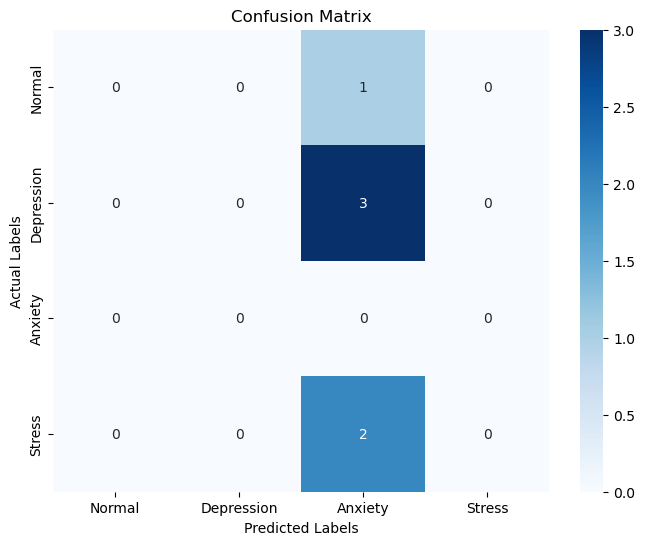

In [42]:
# Cell 7
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = ['Normal', 'Depression', 'Anxiety', 'Stress']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


In [44]:

# Example usage of classify_svc_file
file_path = "./input_files/1_hw00001.svc"
emotion, confidence, probs = classify_svc_file(model, file_path, scaler)
print(f"Predicted emotion: {emotion} (Confidence: {confidence:.2%})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted emotion: Anxiety (Confidence: 25.07%)


In [21]:
# Cell 8
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Print classification report with improved formatting
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)

# Convert classification report to a table
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
rows = [[cls, 
         f"{metrics['precision']:.2f}", 
         f"{metrics['recall']:.2f}", 
         f"{metrics['f1-score']:.2f}", 
         int(metrics['support'])] for cls, metrics in report.items() if cls != 'accuracy']

# Add accuracy row separately
accuracy_row = ["Accuracy", "-", "-", f"{accuracy_score(y_test, y_pred) * 100:.2f}%", "-"]
rows.append(accuracy_row)

# Print the table
print(tabulate(rows, headers, tablefmt="fancy_grid"))

# Compute and display individual scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display overall metrics in a formatted style
print("\nOverall Metrics:")
overall_metrics = [
    ["Metric", "Score"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["Precision (weighted)", f"{precision:.2f}"],
    ["Recall (weighted)", f"{recall:.2f}"],
    ["F1-Score (weighted)", f"{f1:.2f}"]
]

print(tabulate(overall_metrics, headers="firstrow", tablefmt="fancy_grid"))


Classification Report:


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

# END
